In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import PDI.filtros.frecuencia as freq
import PDI.filtros.espacial as espc
import PDI.utils.utils as utils
import PDI.color.color as color
import PDI.histograma.histo as histo

**Se considera el siguiente problema:**  

Se tiene un conjunto de imágenes de portadas de distintos libros, que fueron obtenidas con distintas fuentes de luz, y donde se busca tratar de corregir la iluminación de cada una. El objetivo es que se consiga una restauración sin modificar significativamente los colores originales de la portada, y haciendo posible la visualización de todos los elementos contenidos en la misma, ya sea texto o ciertos dibujos.

Principalmente se trabajará sobre el espacio HSV de las imágenes, para disminuir las alteraciones sobre los colores de las mismas.  
En primer lugar, se buscará mejorar la iluminación de la imagen mediante la aplicación de un filtrado homomórfico sobre el canal **V** del espacio **HSV**. Este filtrado nos permitirá afectar de manera individual las bajas frecuencias, por lo que podremos mejorar la iluminación global de la iamgen, sin afectar de manera considerable la información contenida en altas frecuencias.  
Luego, se aplicarán distintas técnicas tanto en el dominio espacial como frecuencial para mejorar el resultado obtenido en el paso anterior.

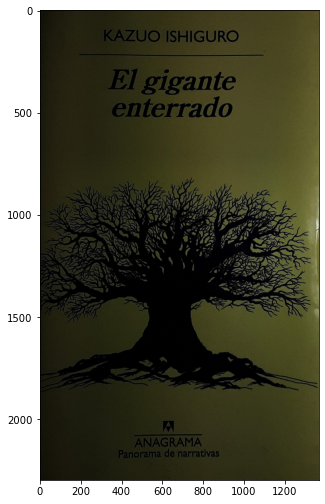

In [31]:
img_bgr = cv.imread("Imagenes/libro5.jpg")
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
plt.figure(figsize=(5,10))
plt.imshow(img);

1- Obtener canales HSV  
2- Filtrado homomorfico al V  
3- Ecualizado local  
4- Transformación gamma/potencia/LUT  
5- Algún filtrado para reducción de ruido  
6- Volver a RGB

### 1- CANALES HSV

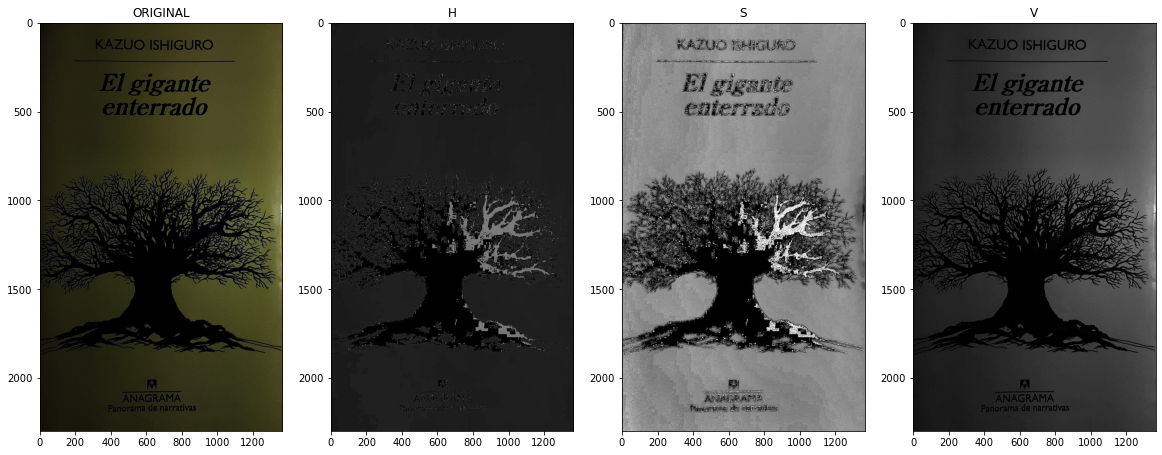

In [3]:
color.plot_color_channels(img, space='hsv')

In [4]:
channels_hsv = cv.split(color.RGB2HSV(img))

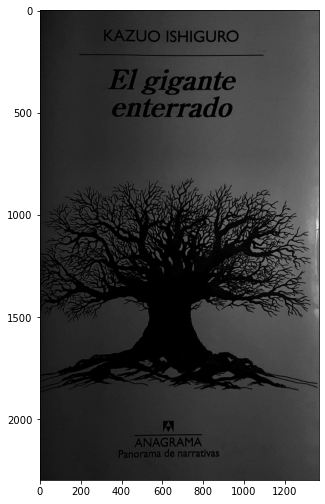

In [5]:
channel_v = channels_hsv[2]
plt.figure(figsize=(5,10))
plt.imshow(channel_v, cmap='gray')

### 2.1 ECUALIZADO DEL CANAL V

In [53]:
channel_v_eqg = histo.eq_global(channel_v)
channel_v_eql = histo.eq_local(channel_v)

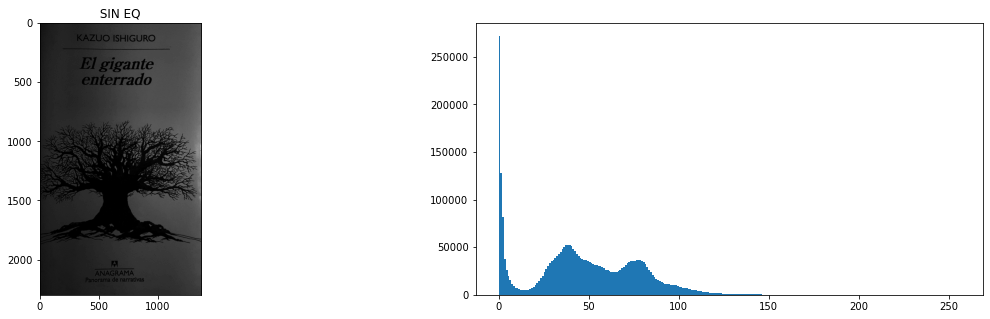

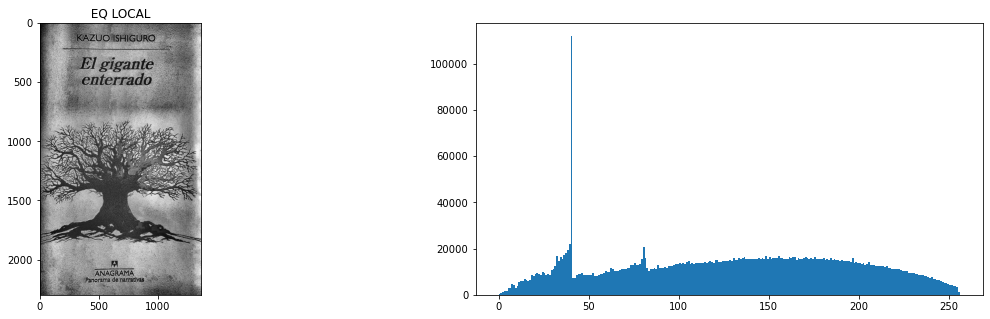

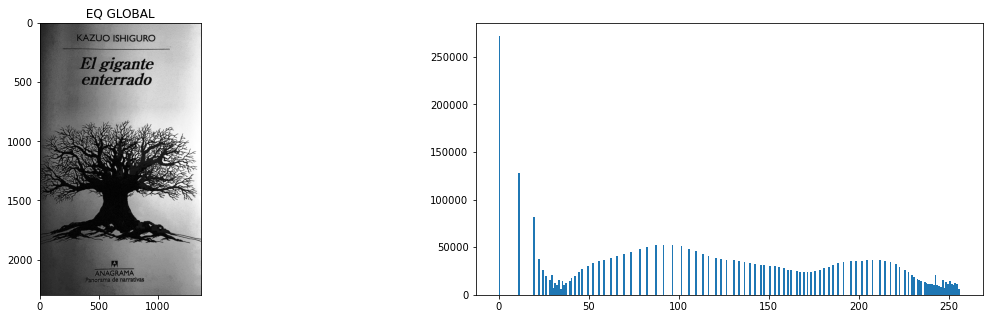

In [54]:
histo.plot_histo([channel_v], figsize=(20,5), patron=(1,2), titulos=[' SIN EQ ', ''])
histo.plot_histo([channel_v], eq='local', figsize=(20,5), patron=(1,2), titulos=[' EQ LOCAL ', ''])
histo.plot_histo([channel_v], eq='global', figsize=(20,5), patron=(1,2), titulos=[' EQ GLOBAL ', ''])

### 2.2- FILTRADO HOMOMORFICO

Del canal **V** ecualizado o sin ecualizar?

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

In [55]:
def update_hm(low,high,fc,n):
    channel_v_hm, filtro_hm = freq.aplicar_homomorfico(channel_v_eqg, low, high, fc, n)
    
    channel_v_hm = channel_v_hm.astype('uint8')
    filtro_hm = filtro_hm.astype('uint8')
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.imshow(filtro_hm, cmap='gray')

    plt.subplot(1,3,2)
    H = low + ((high-low) / (1 + (fc/np.arange(1,256))**(2*n)))
    plt.plot(np.arange(255), H);

    plt.subplot(1,3,3)
    plt.imshow(channel_v_hm, cmap='gray')

interact(update_hm,
        low=widgets.IntSlider(min=-20, max=50, step=1, value=20),
        high=widgets.IntSlider(min=-20, max=20, step=1, value=4),
        fc=widgets.IntSlider(min=0, max=255, step=1, value=80),
        n=widgets.IntSlider(min=0, max=10, step=1, value=1)
    );

interactive(children=(IntSlider(value=20, description='low', max=50, min=-20), IntSlider(value=4, description=…

In [56]:
channel_v_hm, filtro_hm = freq.aplicar_homomorfico(channel_v_eqg, 50,3,100,3)

### 3- ECUALIZADO LOCAL Y GLOBAL

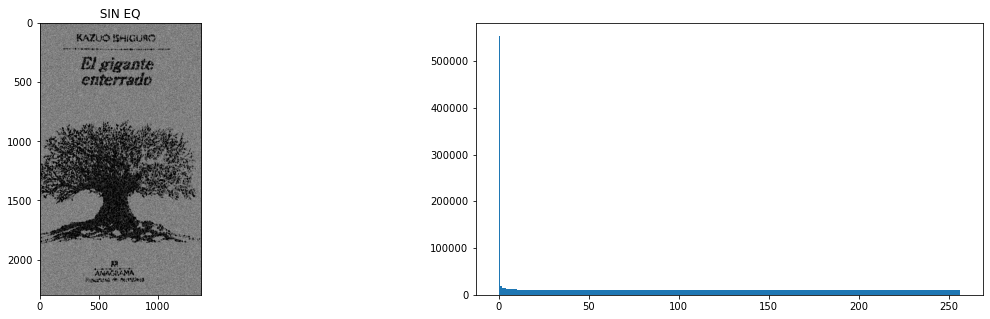

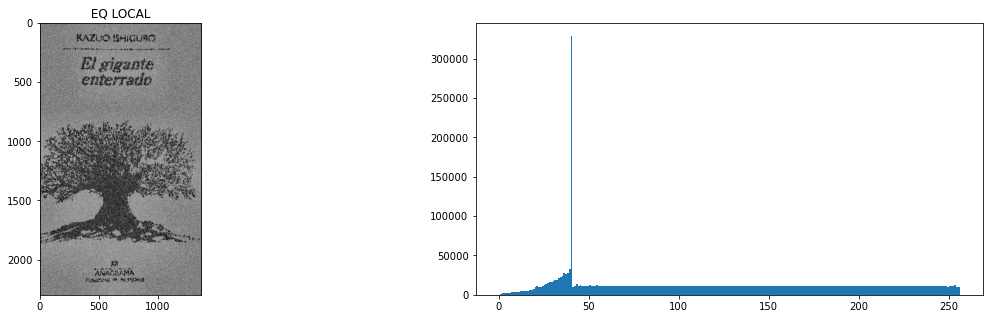

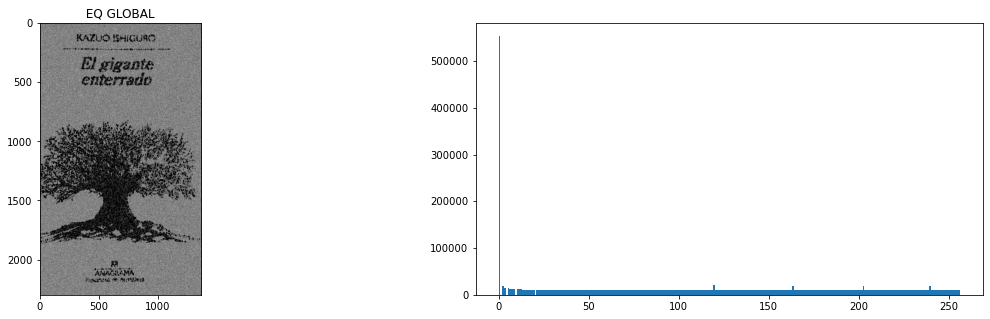

In [57]:
histo.plot_histo([channel_v_hm], figsize=(20,5), patron=(1,2), titulos=[' SIN EQ ', ''])
histo.plot_histo([channel_v_hm], eq='local', figsize=(20,5), patron=(1,2), titulos=[' EQ LOCAL ', ''])
histo.plot_histo([channel_v_hm], eq='global', figsize=(20,5), patron=(1,2), titulos=[' EQ GLOBAL ', ''])

In [58]:
channel_v_hm_eqg = histo.eq_global(channel_v_hm)
channel_v_hm_eql = histo.eq_local(channel_v_hm)

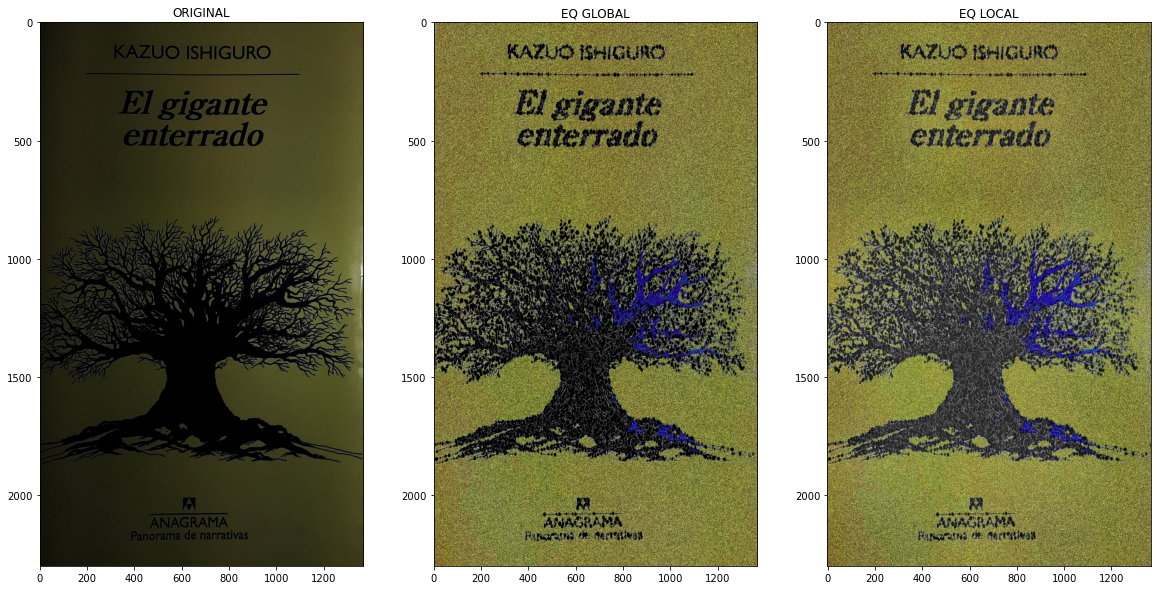

In [59]:
res_rgb_eqg = color.HSV2RGB(cv.merge([channels_hsv[0], channels_hsv[1], channel_v_hm_eqg]))
res_rgb_eql = color.HSV2RGB(cv.merge([channels_hsv[0], channels_hsv[1], channel_v_hm_eql]))
utils.plot([img, res_rgb_eqg, res_rgb_eql], figsize=(20,10), patron=(1,3), gray=False, titulos=['ORIGINAL', 'EQ GLOBAL', 'EQ LOCAL'])

### 4- TRANSFORMACIONES

In [60]:
def update_t(gamma, c):
    t = utils.t_pot(gamma, c)
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,3,1)
    plt.title('SIN CORRECION GAMMA')
    plt.imshow(channel_v_hm_eqg.astype('uint8'), cmap='gray')
    
    plt.subplot(1,3,2)
    plt.title('TRANSF. GAMMA')
    plt.plot(np.arange(255), t[np.arange(255)])
    
    plt.subplot(1,3,3)
    plt.title('CON CORRECION GAMMA')
    plt.imshow(t[channel_v_hm_eqg].astype('uint8'), cmap='gray')
    
interact(update_t, 
         gamma=widgets.FloatSlider(min=0, max=10, step=.1, value=.5),
         c=widgets.FloatSlider(min=0, max=10, step=.1, value=.3)
    );

interactive(children=(FloatSlider(value=0.5, description='gamma', max=10.0), FloatSlider(value=0.3, descriptio…

In [61]:
t_gamma = utils.t_pot(.5, .3)
channel_v_gamma = t_gamma[channel_v_hm_eqg]
channel_v_gamma /= np.max(channel_v_gamma)
channel_v_gamma *= 255

In [62]:
channel_s = channels_hsv[1]

In [63]:
def update_t(gamma, c):
    t = utils.t_pot(gamma, c)
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,3,1)
    plt.title('SIN CORRECION GAMMA')
    plt.imshow(channel_s.astype('uint8'), cmap='gray')
    
    plt.subplot(1,3,2)
    plt.title('TRANSF. GAMMA')
    plt.plot(np.arange(255), t[np.arange(255)])
    
    plt.subplot(1,3,3)
    plt.title('CON CORRECION GAMMA')
    plt.imshow(t[channel_s].astype('uint8'), cmap='gray')
    
interact(update_t, 
         gamma=widgets.FloatSlider(min=0, max=10, step=.1, value=.3),
         c=widgets.FloatSlider(min=0, max=10, step=.1, value=1)
    );

interactive(children=(FloatSlider(value=0.3, description='gamma', max=10.0), FloatSlider(value=1.0, descriptio…

In [64]:
t_gamma = utils.t_pot(.3, 1)
channel_s_gamma = t_gamma[channel_s]
channel_s_gamma /= np.max(channel_s_gamma)
channel_s_gamma *= 255

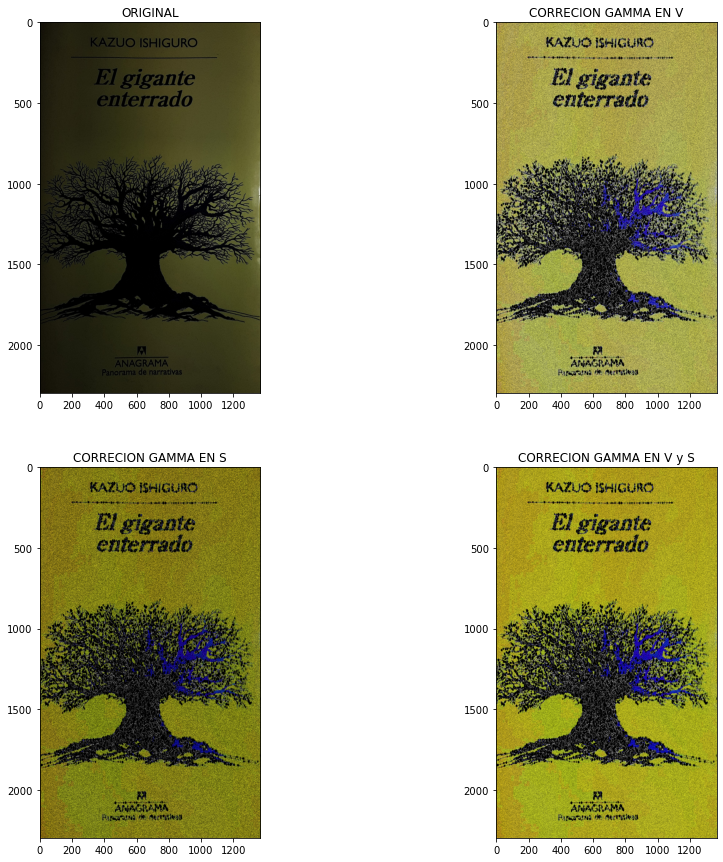

In [65]:
res_rgb_gamma_v = color.HSV2RGB(cv.merge([channels_hsv[0], channels_hsv[1], channel_v_gamma.astype('uint8')]))
res_rgb_gamma_s = color.HSV2RGB(cv.merge([channels_hsv[0], channel_s_gamma.astype('uint8'), channel_v_hm_eqg.astype('uint8')]))
res_rgb_gamma_sv = color.HSV2RGB(cv.merge([channels_hsv[0], channel_s_gamma.astype('uint8'), channel_v_gamma.astype('uint8')]))

utils.plot([img, res_rgb_gamma_v, res_rgb_gamma_s, res_rgb_gamma_sv], 
           figsize=(15,15), patron=(2,2), gray=False, 
           titulos=['ORIGINAL', 'CORRECION GAMMA EN V', 'CORRECION GAMMA EN S', 'CORRECION GAMMA EN V y S'])

### 5- REDUCCION DE RUIDO

In [168]:
channel_v_espectro = freq.get_espectro(channel_v_gamma)

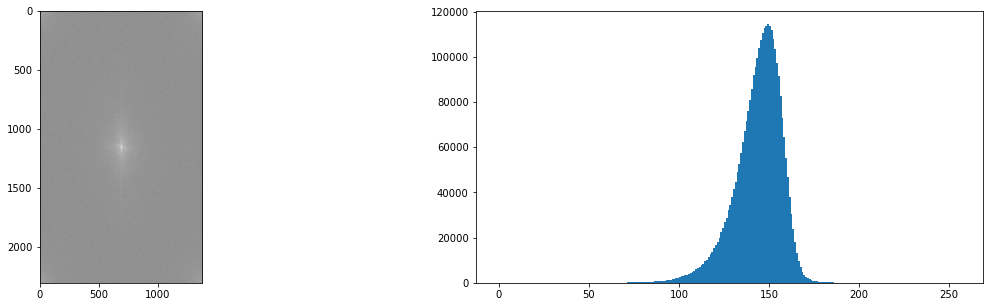

In [170]:
histo.plot_histo([channel_v_espectro.astype('uint8')])

In [65]:
def filtro_uniforme(img, tam_kernel):
    img_modified=np.copy(img)
    img_modified=cv.blur(img_modified,(tam_kernel,tam_kernel))
    return img_modified

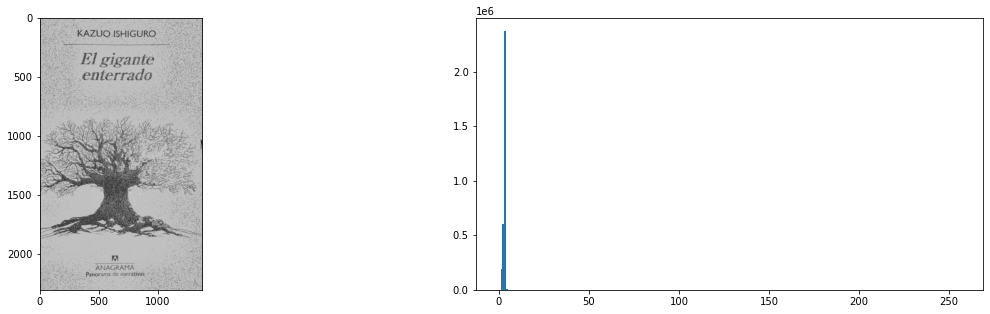

In [171]:
histo.plot_histo([filtro_uniforme(channel_v_gamma.astype('uint8'), 5).astype('uint8')])

In [58]:
def filtro_gaussiano_PB(img, tam_kernel, mu, sigmaX=0, sigmaY=0):
    img_modified=np.copy(img)
    img_modified=cv.GaussianBlur(img_modified,(tam_kernel,tam_kernel), mu,sigmaX,sigmaY)
    return img_modified

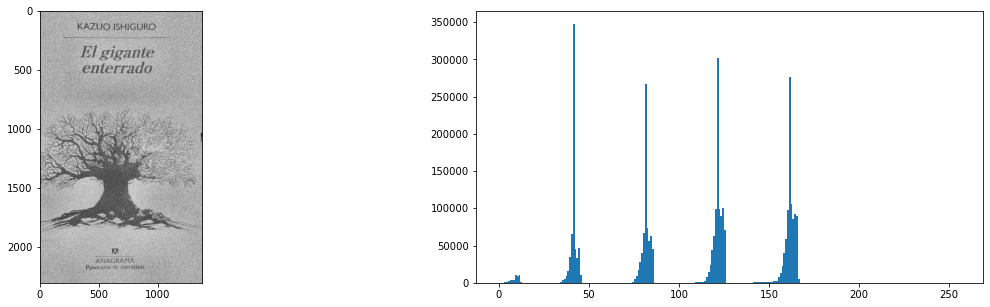

In [70]:
channel_v_gaussPB = filtro_gaussiano_PB(channel_v_gamma, 3, .1, sigmaX=.1, sigmaY=.1)
histo.plot_histo([channel_v_gaussPB.astype('uint8')], eq='local')

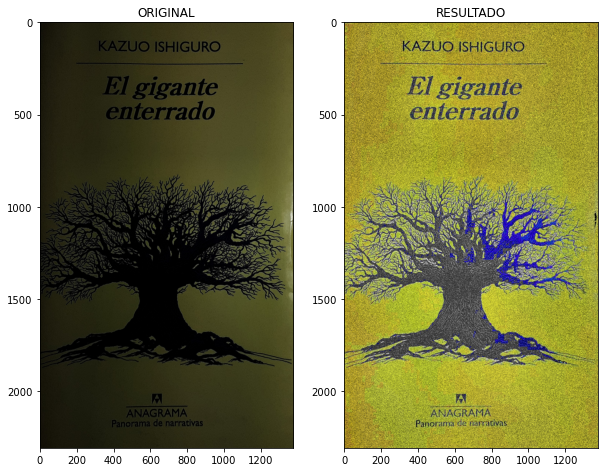

In [72]:
resultado_rgb = color.HSV2RGB(cv.merge([channels_hsv[0], channel_s_gamma.astype('uint8'), histo.eq_global(channel_v_gaussPB.astype('uint8'))]))
utils.plot([img, resultado_rgb], figsize=(10,10), patron=(1,2), gray=False, titulos=['ORIGINAL', 'RESULTADO'])

In [92]:
def filtro_MediaGeometrica(img, tam_kernel):
    img_modified=np.copy(img).astype(np.float32)
    
    (s, t) = img_modified.shape
    for i in range(0, s-tam_kernel+1):
        for j in range(0, t-tam_kernel+1):
            acum = 1
            for k in range(i, i+tam_kernel):
                for o in range(j, j+tam_kernel):
                    acum = acum * img_modified[k, o]
            img_modified[i,j] = float(pow(acum, 1.0/(tam_kernel*tam_kernel)))
    return img_modified

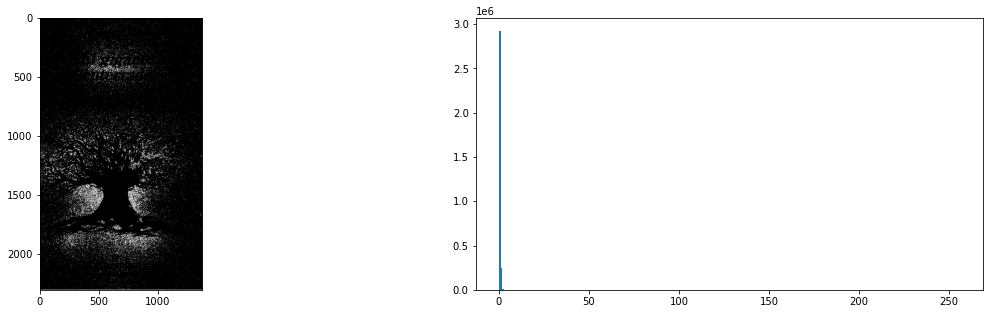

In [103]:
histo.plot_histo([filtro_MediaGeometrica(channel_v_gamma, 5)])

In [101]:
def filtro_puntoMedio(img,tam_kernel):
    img_modified = np.copy(img).astype(np.float)
    p_medio = np.int(np.ceil(tam_kernel/2))
    H,W=img.shape
    
    for i in range(0,H-tam_kernel+1):
        for j in range(0,W-tam_kernel+1):
            sub_img=img[i:i+tam_kernel,j:j+tam_kernel]
            maximo = np.max(sub_img)
            minimo = np.min(sub_img)
            img_modified[i+p_medio,j+p_medio] = 0.5*(minimo+maximo)
    return img_modified

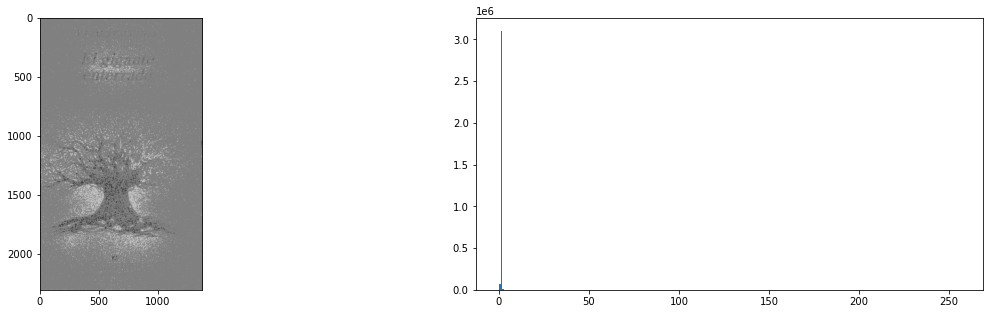

In [102]:
histo.plot_histo([filtro_puntoMedio(channel_v_gamma, 5)])